In [26]:
#this is a cylinderical light sheet simulation

In [27]:
#import the necessary modules
%pylab inline
import os
import pyoptic2 as pyo
from pyoptic2.util import zemax
from pyoptic2.display import plot2d, plot_system2d

Populating the interactive namespace from numpy and matplotlib


In [28]:
print(os.getcwd())

c:\localfiles\pyoptic2\mysetup


In [ ]:

# 指定 mysetup 目录
zar_file_name = 'LJ1567L1_Zemax.zar'
mysetup_dir = os.getcwd()

# 构建 .zar 文件的完整路径
zar_file_path = os.path.join(mysetup_dir, zar_file_name)
print(zar_file_path)

# read .zar file
cylindrical_lens = zemax.read_cached_zar(zar_file_path)

# put the light source
src = pyo.PointSource('light source', pyo.Placement([0,0,0], [0,1,0]), NA=0.12, color=(1,0,0), wavelength=642.)
r = src.principle_ray

#generate the system
s = pyo.System()

mirror1, r = s.add(pyo.Mirror.rotate_deg(r.prop(100), axis=[0,0,1],angle=0.), r)


c:\localfiles\pyoptic2\mysetup\LJ1567L1_Zemax.zar


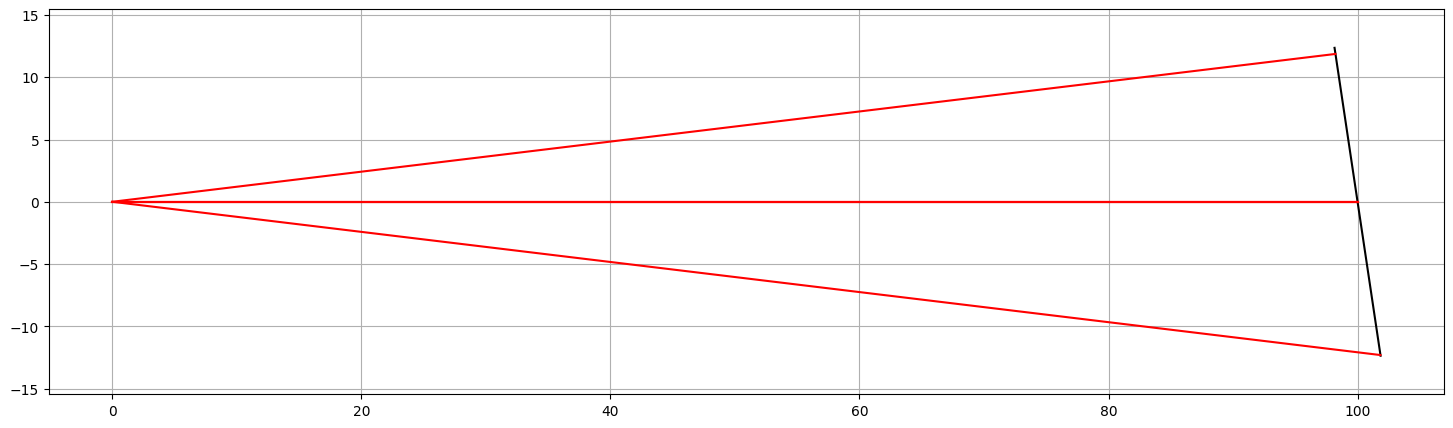

In [30]:
#Plot the system
# plot our optical system. This is a matplotlib plot, and you can use all the matplotlib plotting functions
# on top of the optical plots.
figure(figsize=(18,5))
plot_system2d(s, 'xy') #plot the system
plot2d(s.propagate(src.chief_rays), 'xy') #plot the on-axis, and extreme rays
#plot2d(s.propagate(src.pupil_rays), 'xy') #plot rays evenly distributed across the pupil
axis('equal')
grid()